In [1]:
import os
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import matplotlib.pyplot as plt
import numpy as np
import OT2_Ouzo_Commands as ot2_commands
from opentrons import simulate, execute, protocol_api

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Loading json containers...
Json container file load complete, listing database
Found 0 containers to add. Starting migration...
Database migration complete!


In [4]:
# os.getcwd()
# csv_file_location = os.getcwd() + '\\Ouzo_Experiment_Plan_Testing.csv'
experiment_dict = create.get_experiment_plan(r"C:\Users\Edwin\Desktop\Run 0917-20200918T211621Z-001\Run 0917\09_17_20_P_TL_Scan.csv") # Intialize master dictionary from excel sheet
component_dict = create.dict_creator(experiment_dict, 'Component') # Gather all information concerning components into one dictionary
stock_dict = create.dict_creator(experiment_dict, 'Stock') 
opentrons_dict = create.dict_creator(experiment_dict, 'OT2')
sample_canidates = create.generate_candidate_lattice_concentrations(component_dict) # incorperate
total_sample_mass = experiment_dict['Sample Mass']
sample_stock_volumes = create.calculate_volumes(total_sample_mass, sample_canidates, component_dict, stock_dict) # created in uL
volume_filtered_samples = create.volume_filter(30,1000,sample_stock_volumes) # here is where you need to grab the samples
component_volume_lists = create.rearrange_volumes(volume_filtered_samples)
# make a wrapper function for all of these, only available for troubleshooting/debuggin

In [13]:
rearr = create.rearrange_volumes(sample_canidates)


[[0.0001,
  0.00014705882352941175,
  0.0001941176470588235,
  0.00024117647058823527,
  0.00028823529411764703,
  0.0003352941176470588,
  0.00038235294117647055,
  0.0004294117647058823,
  0.0004764705882352941,
  0.0005235294117647059,
  0.0005705882352941177,
  0.0006176470588235294,
  0.0006647058823529412,
  0.0007117647058823529,
  0.0007588235294117647,
  0.0008058823529411765,
  0.0008529411764705882,
  0.0009,
  0.0001,
  0.00014705882352941175,
  0.0001941176470588235,
  0.00024117647058823527,
  0.00028823529411764703,
  0.0003352941176470588,
  0.00038235294117647055,
  0.0004294117647058823,
  0.0004764705882352941,
  0.0005235294117647059,
  0.0005705882352941177,
  0.0006176470588235294,
  0.0006647058823529412,
  0.0007117647058823529,
  0.0007588235294117647,
  0.0008058823529411765,
  0.0008529411764705882,
  0.0009,
  0.0001,
  0.00014705882352941175,
  0.0001941176470588235,
  0.00024117647058823527,
  0.00028823529411764703,
  0.0003352941176470588,
  0.0003823529

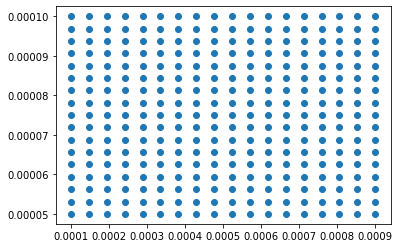

In [15]:
plt.scatter(rearr[0],rearr[1])

In [5]:
len(component_volume_lists[0]) # 

47

In [27]:

protocol = simulate.get_protocol_api('2.0')
ot2_commands.run(protocol, experiment_dict, opentrons_dict, component_volume_lists) # alright cmon wig!

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Picking up tip from A1 of Opentrons 96 Tip Rack 300 µL on 4
Transferring 48.75000283042516 from A1 of Corning 48 Well Plate 1.6 mL Flat on 1 to A1 of Corning 48 Well Plate 1.6 mL Flat on 2
Aspirating 48.75000283042516 uL from A1 of Corning 48 Well Plate 1.6 mL Flat on 1 at 150.0 uL/sec
Dispensing 48.75000283042516 uL into A1 of Corning 48 Well Plate 1.6 mL Flat on 2 at 300.0 uL/sec
Transferring 48.75000283042516 from A1 of Corning 48 Well Plate 1.6 mL Flat on 1 to B1 of Corning 48 Well Plate 1.6 mL Flat on 2
Aspirating 48.75000283042516 uL from A1 of Corning 48 Well Plate 1.6 mL Flat on 1 at 150.0 uL/sec
Dispensing 48.75000283042516 uL into B1 of Corning 48 Well Plate 1.6 mL Flat on 2 at 300.0 uL/sec
Transferring 48.75000283042516 from A1 of Corning 48 Well Plate 1.6 mL Flat on 1 to C1 of Corning 48 Well Plate 1.6 mL Flat on 2
Aspirating 48.75000283042516 uL from A1 of Corning 48 Well Plate 1.6 mL Flat on 1 at 150.0 uL/sec
Dispensing 48.75000283042516 uL into C1 of Corning 48 Well Plat

In [8]:
 # need to go into this function and extract the wtf information or else that information is lost.

In [18]:
print('sample filtered out =', len(sample_stock_volumes)-len(volume_filtered_samples))
print('samples remaining =', len(volume_filtered_samples))

sample filtered out = 718
samples remaining = 178
